In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2023-09-11 14:33:03.343093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading and preprocessing Dataset

In [2]:
df = pd.read_csv("data/SeoulBikeData.csv")
df = df.drop(["Date", "Holiday", "Seasons"], axis=1)
cols = [
    "bike_count", "hour", "temp",
    "humidity","wind", "visibility",
    "dew_pt_temp", "radiation", "rain",
    "snow", "functional",
]
df.columns = cols
df["functional"] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop("hour", axis=1)
df = df.drop(["wind", "visibility", "functional"], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


## Train, Test, Valid Split

In [3]:
train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

def get_xy(dataframe: pd.DataFrame, y_label, x_labels=None):
    dataframe = dataframe.copy()
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

print(train.shape)
print(valid.shape)
print(test.shape)

(219, 7)
(73, 7)
(73, 7)


## Simple Regression with Neural Network

In [4]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_valid_temp, y_valid_temp = get_xy(valid, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])
print(X_train_temp.shape)
print(y_train_temp.shape)

(219, 1)
(219, 1)


In [7]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1, ), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

2023-09-11 14:09:22.450205: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

temp_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
)

In [9]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=500,
    validation_data=(X_valid_temp, y_valid_temp),
)

Epoch 1/500
7/7 [==============================] - 2s 36ms/step - loss: 644872.0625 - val_loss: 717696.0625
Epoch 2/500
7/7 [==============================] - 0s 10ms/step - loss: 643595.1250 - val_loss: 716287.6250
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 642310.4375 - val_loss: 714878.5625
Epoch 4/500
7/7 [==============================] - 0s 8ms/step - loss: 641102.8750 - val_loss: 713443.3750
Epoch 5/500
7/7 [==============================] - 0s 8ms/step - loss: 639852.6250 - val_loss: 712021.5000
Epoch 6/500
7/7 [==============================] - 0s 9ms/step - loss: 638561.8750 - val_loss: 710627.3125
Epoch 7/500
7/7 [==============================] - 0s 8ms/step - loss: 637314.6250 - val_loss: 709227.0625
Epoch 8/500
7/7 [==============================] - 0s 7ms/step - loss: 636058.7500 - val_loss: 707830.2500
Epoch 9/500
7/7 [==============================] - 0s 8ms/step - loss: 634852.5000 - val_loss: 706404.7500
Epoch 10/500
7/7 [=================

In [5]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

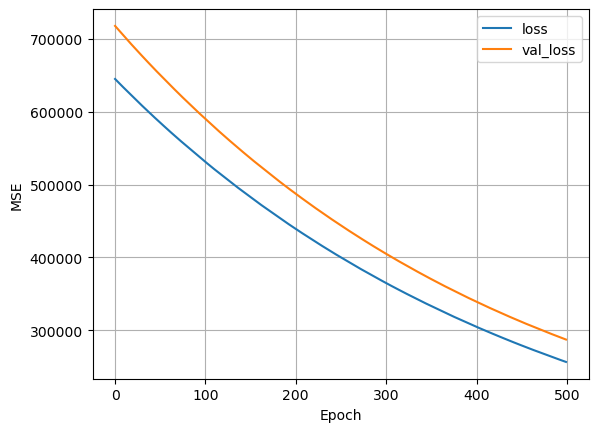

In [11]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


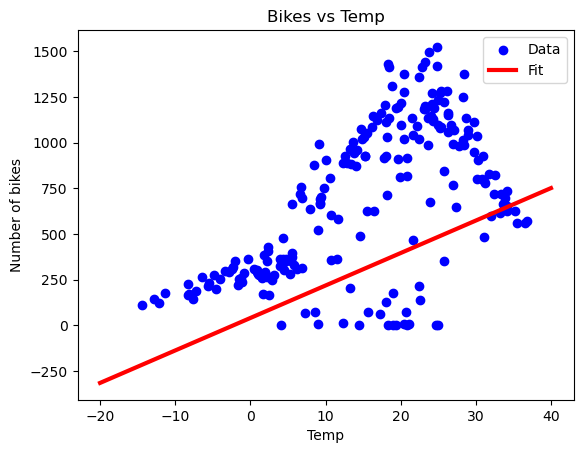

In [12]:
x = np.linspace(-20, 40, 100)
y = temp_nn_model.predict(x.reshape(-1, 1))
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
plt.plot(x, y, label="Fit", color="red", linewidth=3)
plt.title("Bikes vs Temp")
plt.xlabel("Temp")
plt.ylabel("Number of bikes")
plt.legend()
plt.show()

## More dense NN model

In [6]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1, ), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

2023-09-11 14:33:32.003737: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu"),
])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mean_squared_error",
)

In [8]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    epochs=100,
    validation_data=(X_valid_temp, y_valid_temp),
)

Epoch 1/100
7/7 [==============================] - 1s 76ms/step - loss: 715086.7500 - val_loss: 642832.0000
Epoch 2/100
7/7 [==============================] - 0s 50ms/step - loss: 714947.5625 - val_loss: 642661.1250
Epoch 3/100
7/7 [==============================] - 0s 36ms/step - loss: 714749.8750 - val_loss: 642467.6250
Epoch 4/100
7/7 [==============================] - 0s 37ms/step - loss: 714536.0625 - val_loss: 642259.3750
Epoch 5/100
7/7 [==============================] - 0s 36ms/step - loss: 714300.3750 - val_loss: 642025.9375
Epoch 6/100
7/7 [==============================] - 0s 42ms/step - loss: 714042.2500 - val_loss: 641764.8125
Epoch 7/100
7/7 [==============================] - 0s 49ms/step - loss: 713746.1875 - val_loss: 641463.0000
Epoch 8/100
7/7 [==============================] - 0s 40ms/step - loss: 713404.0625 - val_loss: 641114.0000
Epoch 9/100
7/7 [==============================] - 0s 29ms/step - loss: 713020.4375 - val_loss: 640712.6875
Epoch 10/100
7/7 [==========

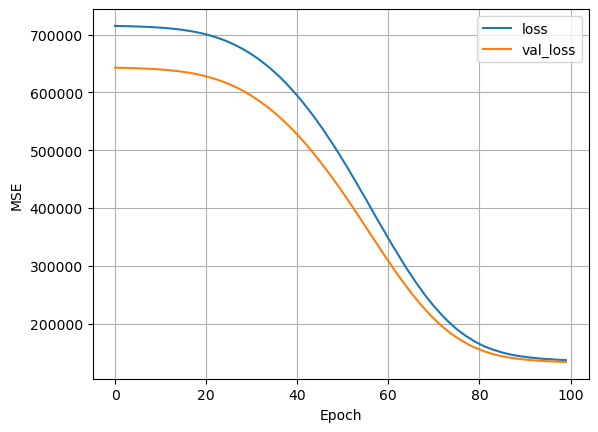

In [9]:
plot_loss(history)

4/4 [==============================] - 0s 11ms/step


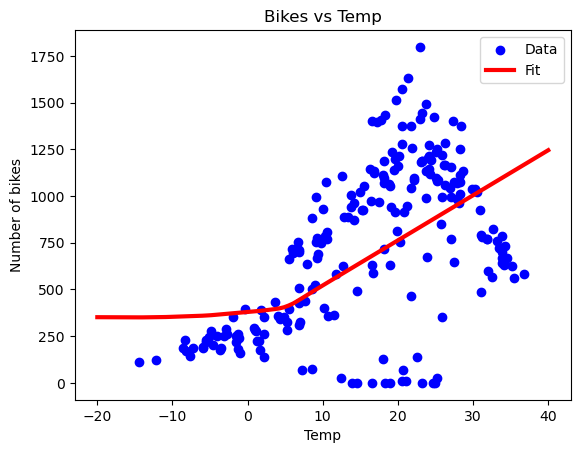

In [10]:
x = np.linspace(-20, 40, 100)
y = nn_model.predict(x.reshape(-1, 1))
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
plt.plot(x, y, label="Fit", color="red", linewidth=3)
plt.title("Bikes vs Temp")
plt.xlabel("Temp")
plt.ylabel("Number of bikes")
plt.legend()
plt.show()